### Visualizing the distribution of the observations

### Load the required libraries

In [45]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SSSSBSBB'

figure_dir = 'report_figures/'


from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)


Populating the interactive namespace from numpy and matplotlib


/home/wesley6920/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['load']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


### Select data for a particular station and measurement type

In [46]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USC00293533')

df1 = sqlContext.sql(Query)

rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)


## my code
Query2 = "SELECT DISTINCT station FROM weather\n\tWHERE measurement='%s'"%('PRCP')
df2 = sqlContext.sql(Query2)
print df2.count()
##df2.show(140)
## end of my code

144


### Script for plotting yearly plots

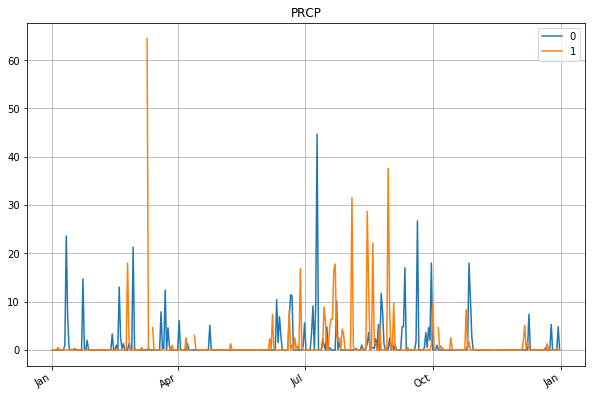

In [47]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='PRCP')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [48]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    ## my code
    
    figuretitle = ''
    ## end of my code
    for m in pair:
        axis = axes[j]
        j+=1
        ##mycode
        subtitle = func(m,fig,axis)    
        figuretitle = figuretitle + subtitle
    figuretitle = figuretitle + '.png'    
    fig.savefig(figure_dir + figuretitle)    
    ##end of my code
    
## my code
def plot_single(thing, func):
    fig, X = subplots(1,1, figsize=(10,6))
    ##axes = X.reshape(1)
    ##axis = axes[0]
    figuretitle = ''
    subtitle = func(thing, fig, X)
    figuretitle = figuretitle + subtitle + '.png'
    fig.savefig(figure_dir + figuretitle)
## end of mycode    
    
def plot_valid(m,fig,axis):
    ## my code
    ##print STAT[m].keys()
    ## end of my code
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    return ('valid-counts ' + m)
    
    

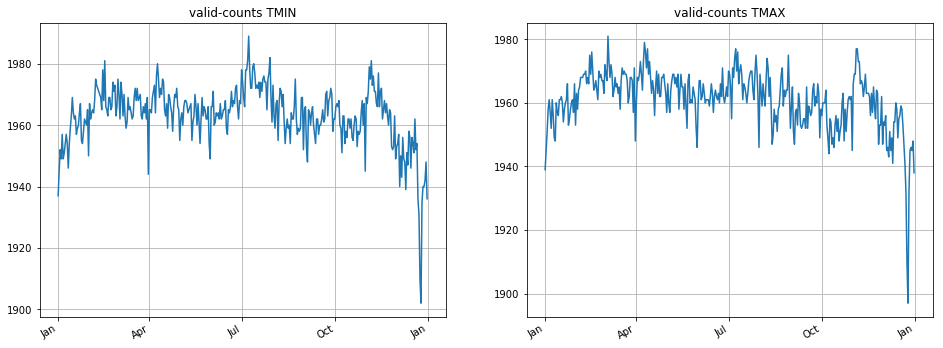

In [49]:
plot_pair(['TMIN','TMAX'],plot_valid)

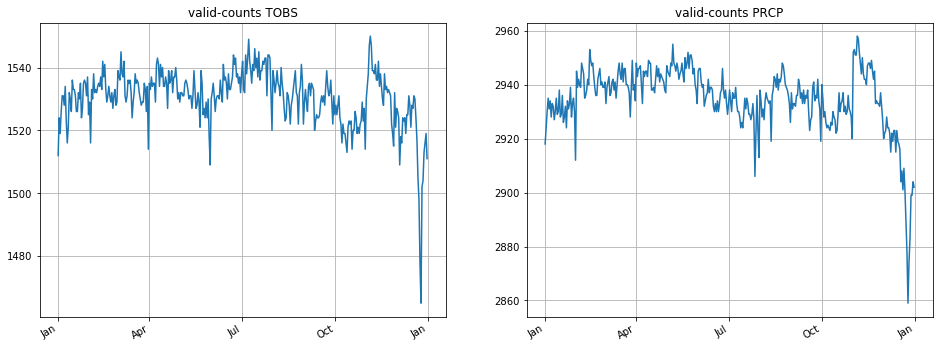

In [50]:
plot_pair(['TOBS','PRCP'],plot_valid)

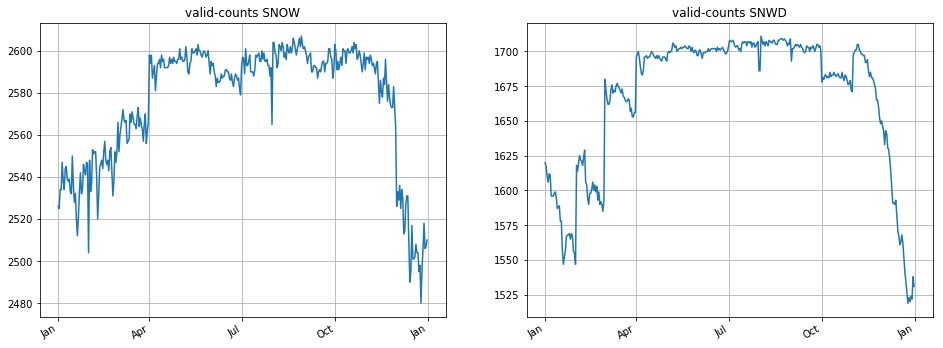

In [51]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [52]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean'] 
    std=np.sqrt(STAT[m]['Var'])
    if(m != 'SNOW' and m != 'SNWD'):## other measurement are in unit of tenths of mm or C, need to change unit
        mean = mean/10.0
        std = std/10.0
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    mylabels = ['mean - std','mean','mean + std']
    ylabels = None
    if m == 'TMAX' or m == 'TMIN' or m == 'TOBS':
        ylabels = 'Degree Celsius'
    else:
        ylabels = 'Millimeter'
    YP.plot(graphs,fig,axis,labels = mylabels, title='Mean+-std_'+m, ylabel = ylabels)
    return ('Mean+-std_'+m)

def plot_mean(m,fig,axis):
    mean=STAT[m]['Mean'] 
    std=np.sqrt(STAT[m]['Var'])
    if(m != 'SNOW' and m != 'SNWD'):## other measurement are in unit of tenths of mm or C, need to change unit
        mean = mean/10.0
        std = std/10.0
    graphs=np.vstack([mean]).transpose()
    mylabels = ['mean']
    ylabels = None
    if m == 'TMAX' or m == 'TMIN' or m == 'TOBS':
        ylabels = 'Degree Celsius'
    else:
        ylabels = 'Millimeter'
    YP.plot(graphs,fig,axis,labels = mylabels, title=m +' Mean', ylabel = ylabels)
    return (m + '_Mean')

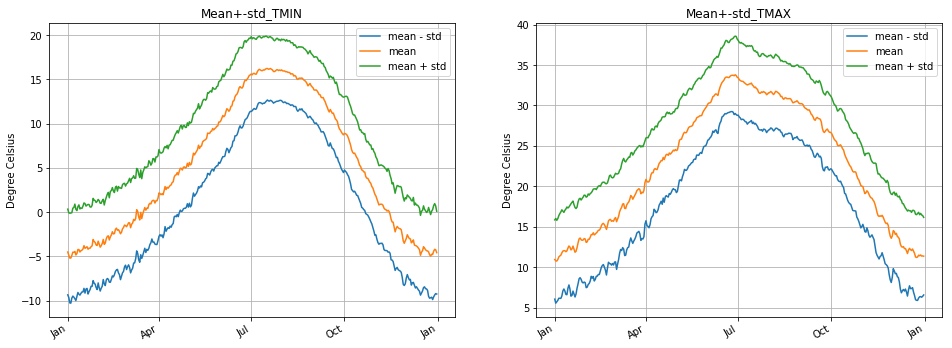

In [53]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

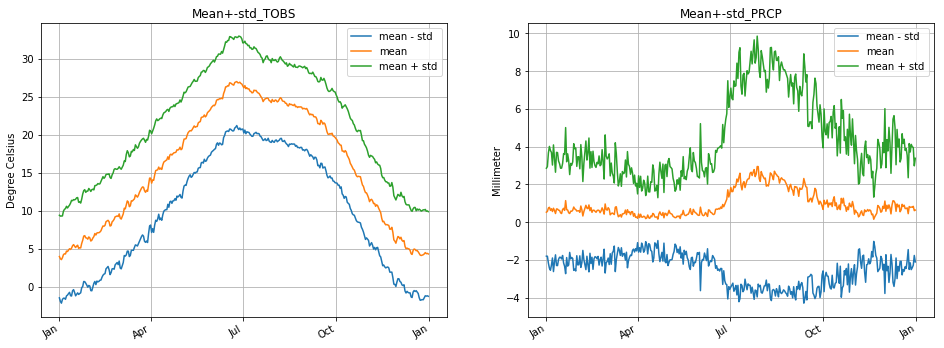

In [54]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

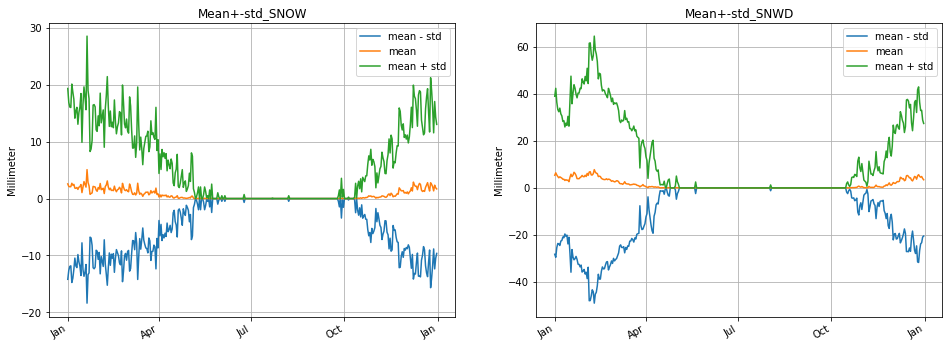

In [55]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting SNWD Mean


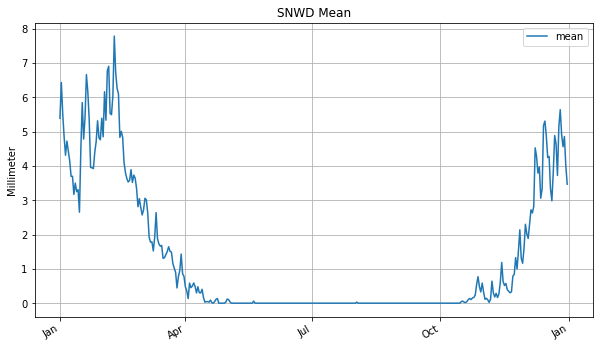

In [56]:
plot_single('SNWD', plot_mean)

### plotting top  eigenvectors

In [57]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    mylabels = ['eig1', 'eig2', 'eig3']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m, labels = mylabels)
    return ('Top Eigenvectors '+m)

### plotting top 4 eigenvectors of SNWD 

In [58]:
def plot_eigen4(m,fig,axis):
    EV=STAT[m]['eigvec']
    mylabels = ['eig1', 'eig2', 'eig3', 'eig4']
    YP.plot(EV[:,:4],fig,axis,title='Top Eigenvectors '+m, labels = mylabels)
    return ('Top Eigenvectors '+m)

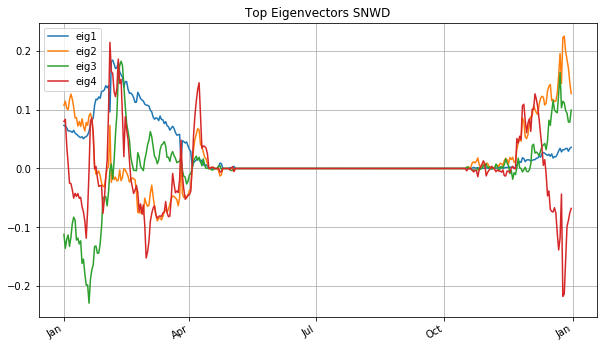

In [59]:
plot_single('SNWD', plot_eigen4)

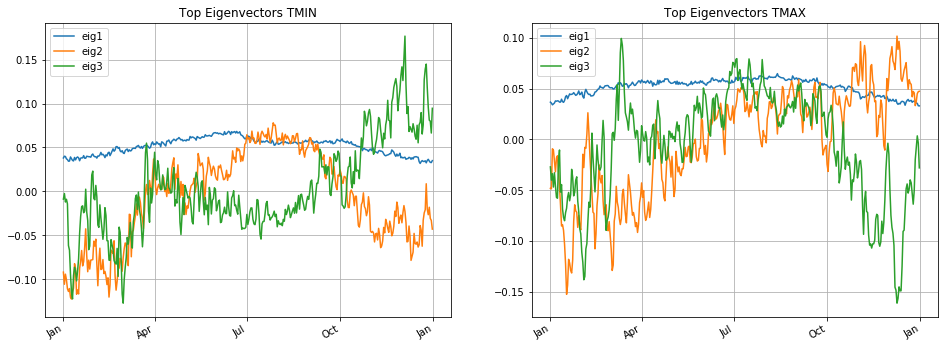

In [60]:
plot_pair(['TMIN','TMAX'],plot_eigen)

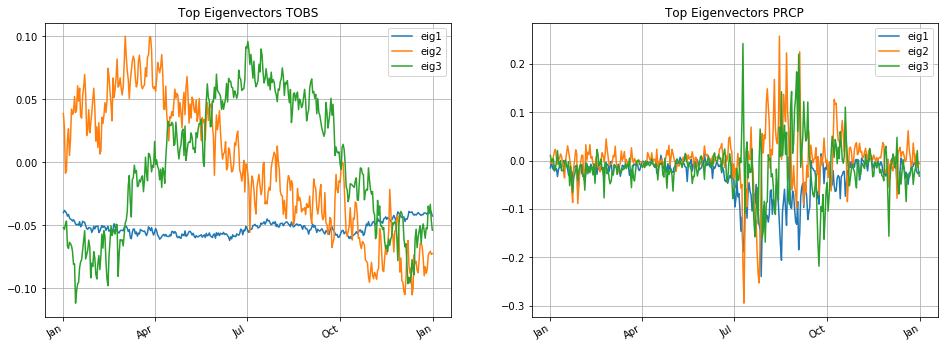

In [61]:
plot_pair(['TOBS','PRCP'],plot_eigen)

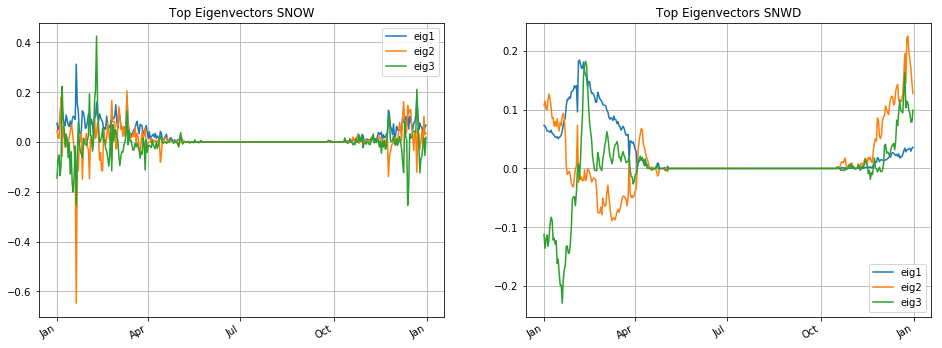

In [62]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [63]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

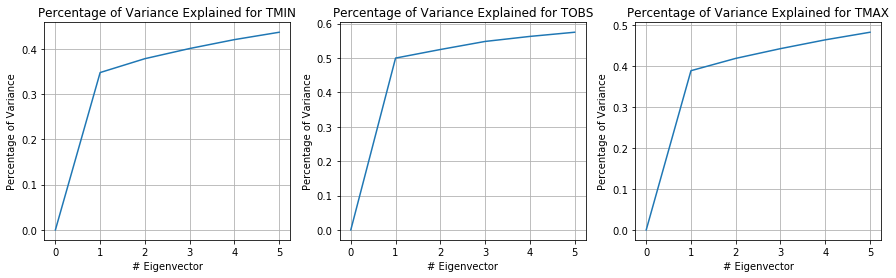

In [64]:
f=plt.figure(figsize=(15,4))
figuretitle = 'PV_Explained_' + ('_'.join(['TMIN', 'TOBS', 'TMAX'])) + '.png'
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: 
    pltVarExplained(j)
    j+=1
f.savefig(figure_dir + figuretitle)  

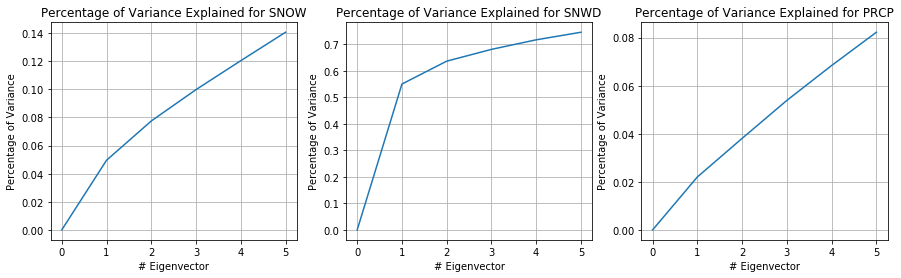

In [65]:
f=plt.figure(figsize=(15,4))
figuretitle = 'PV_Explained_' + ('_'.join(['SNOW', 'SNWD', 'PRCP'])) + '.png'
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 
f.savefig(figure_dir + figuretitle) 

In [66]:
sc.stop()